# Import Libraries

In [1]:
import os
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import torch.optim as optim
import yaml
from tqdm import tqdm

import sys
sys.path.append('../')
from src.conformer import *
from src.data_loader import *
from src.train import *

# Set the Device

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Read Hyperparameters

In [3]:
with open("../configs/training_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access hyperparameters
BATCH_SIZE = config["hyperparameters"]["BATCH_SIZE"]
NUM_EPOCHS = config["hyperparameters"]["NUM_EPOCHS"]
LEARNING_RATE = config["hyperparameters"]["LEARNING_RATE"]
WEIGHT_DECAY = config["hyperparameters"]["WEIGHT_DECAY"]

# Access model parameters
INPUT_DIM = config["model"]["INPUT_DIM"]
D_MODEL = config["model"]["D_MODEL"]
NUM_HEADS = config["model"]["NUM_HEADS"]
D_FF = config["model"]["D_FF"]
NUM_LAYERS = config["model"]["NUM_LAYERS"]
KERNEL_SIZE = config["model"]["KERNEL_SIZE"]
DROPOUT = config["model"]["DROPOUT"]
VOCAB_SIZE = config["model"]["VOCAB_SIZE"]
EARLY_STOPPING_PATIENCE = config["model"]["EARLY_STOPPING_PATIENCE"]
NO_IMPROVE_EPOCHS = config["model"]["NO_IMPROVE_EPOCHS"]

# Load the Model

In [4]:
 # Initialize model
model = Conformer(
        input_dim=INPUT_DIM,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        d_ff=D_FF,
        num_layers=NUM_LAYERS,
        kernel_size=KERNEL_SIZE,
        dropout=DROPOUT,
        vocab_size=VOCAB_SIZE
    ).to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Estimate model storage (in MB)
param_size = 4 # float32 size
storage_needed = total_params * param_size / (1024 ** 2)
print(f"Model storage required: {storage_needed:.2f} MB")

Total parameters: 82,128,927
Model storage required: 313.30 MB


# Test all the models and calculate CER, WER

In [7]:
import jiwer
import time
from tabulate import tabulate

val_dataset = LibriSpeechDataset(root="../data", split="dev-clean")

reference = "In the ancient land of Eldoria, where the skies were painted with shades of mystic hues and the forests whispered secrets of old, there existed a dragon named Zephyros. Unlike the fearsome tales of dragons that plagued human hearts with terror, Zephyros was a creature of wonder and wisdom, revered by all who knew of his existence."  # Reference text

# Store the results in a list
results = []

for i in range(23):
    checkpoint = torch.load(f"../models/conformer_checkpoint_epoch_{i+1}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Define optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    warmup_epochs = 5  # Number of warmup epochs
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=LEARNING_RATE * 0.1)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    model.to(device)
    model.eval()

    # Inference
    start_time = time.time()
    predicted_output = inference(model, val_dataset, "../audios/audio_long.wav", device)  # Replace with your actual inference code
    inference_time = time.time() - start_time

    # Calculate WER and CER
    wer = jiwer.wer(reference, predicted_output)
    cer = jiwer.cer(reference, predicted_output)

    # Append result
    results.append([f"Epoch {i+1}", predicted_output, wer, cer, inference_time])

# Display results in a table
headers = ["Epoch", "Model Output", "WER", "CER", "Inference Time (s)"]
print(tabulate(results, headers=headers, tablefmt="grid"))


+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------+----------------------+
| Epoch    | Model Output                                                                                                                                                                                                                                                                                                                             |      WER |       CER |   Inference Time (s) |
+==========+================================================================================================================================================================================================================

# Test model 21 on test-clean

In [29]:
import torch
import torchaudio
import numpy as np
from torchaudio.datasets import LIBRISPEECH
from sklearn.metrics import accuracy_score
from jiwer import wer, cer  # You will need to install jiwer via `pip install jiwer`

# Assuming model and dataset class are already defined as in the previous code
# Load test dataset (test-clean split)
test_dataset = LibriSpeechDataset(root="../data", split="test-clean")

# Define DataLoader for test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4
)

checkpoint = torch.load(f"../models/conformer_checkpoint_epoch_21.pt")
model.load_state_dict(checkpoint['model_state_dict'])
    
# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=LEARNING_RATE * 0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
model.to(device)
model.eval()
print(device)

# Function to calculate CER and WER
def calculate_cer_wer(model, test_loader, dataset, device):
    model.eval()  # Set model to evaluation mode
    total_wer = 0
    total_cer = 0
    total_samples = 0
    
    with torch.no_grad():
        for features, tokens, feature_lengths, token_lengths in tqdm(test_loader):
            features = features.to(device)
            tokens = tokens.to(device)
            
            # Forward pass
            outputs = model(features)  # [batch_size, seq_len, vocab_size]
            
            # Decode model outputs to text
            pred_texts = decode_predictions(outputs, dataset)
            target_texts = [dataset.decode(tok) for tok in tokens]
            
            # Calculate WER and CER
            for pred, target in zip(pred_texts, target_texts):
                total_wer += wer(target, pred)
                total_cer += cer(target, pred)
                total_samples += 1
                
    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples
    
    return avg_wer, avg_cer

# Calculate CER and WER
avg_wer, avg_cer = calculate_cer_wer(model, test_loader, test_dataset, device)

print(f"Average WER: {avg_wer * 100:.2f}%")
print(f"Average CER: {avg_cer * 100:.2f}%")


cuda


100%|██████████| 655/655 [03:32<00:00,  3.08it/s]

Average WER: 18.59%
Average CER: 5.68%


# Plot CER and WER over Epoch on test-clean

In [ ]:
import torch
import torchaudio
import numpy as np
from torchaudio.datasets import LIBRISPEECH
from sklearn.metrics import accuracy_score
from jiwer import wer, cer  # You will need to install jiwer via `pip install jiwer`

# Assuming model and dataset class are already defined as in the previous code
# Load test dataset (test-clean split)
test_dataset = LibriSpeechDataset(root="../data", split="test-clean")

# Define DataLoader for test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4
)

# Function to calculate CER and WER
def calculate_cer_wer(model, test_loader, dataset, device):
    model.eval()  # Set model to evaluation mode
    total_wer = 0
    total_cer = 0
    total_samples = 0
    
    with torch.no_grad():
        for features, tokens, feature_lengths, token_lengths in test_loader:
            features = features.to(device)
            tokens = tokens.to(device)
            
            # Forward pass
            outputs = model(features)  # [batch_size, seq_len, vocab_size]
            
            # Decode model outputs to text
            pred_texts = decode_predictions(outputs, dataset)
            target_texts = [dataset.decode(tok) for tok in tokens]
            
            # Calculate WER and CER
            for pred, target in zip(pred_texts, target_texts):
                total_wer += wer(target, pred)
                total_cer += cer(target, pred)
                total_samples += 1
                
    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples
    
    return avg_wer, avg_cer

avg_wer_list = []
avg_cer_list = []
epochs = []

for i in tqdm(range(23)):
    
    checkpoint = torch.load(f"../models/conformer_checkpoint_epoch_{i+1}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
        
    # Define optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=LEARNING_RATE * 0.1)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    model.to(device)
    model.eval()
    
    # Calculate CER and WER
    avg_wer, avg_cer = calculate_cer_wer(model, test_loader, test_dataset, device)
    
    avg_wer_list.append(avg_wer)
    avg_cer_list.append(avg_cer)
    epochs.append(i+1)
    
    
# Plot WER and CER over epochs
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WER
ax1.set_xlabel('Epoch')
ax1.set_ylabel('WER', color='tab:blue')
ax1.plot(epochs, avg_wer_list, color='tab:blue', marker='o', label='WER')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for CER
ax2 = ax1.twinx()
ax2.set_ylabel('CER', color='tab:orange')
ax2.plot(epochs, avg_cer_list, color='tab:orange', marker='s', label='CER')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set x-ticks to integer values only (1, 2, 3, ...)
ax1.set_xticks(np.arange(1, len(epochs) + 1))

# Add title and grid
plt.title('WER and CER over Epochs')
ax1.grid(True)

# Show plot
plt.tight_layout()
plt.show()

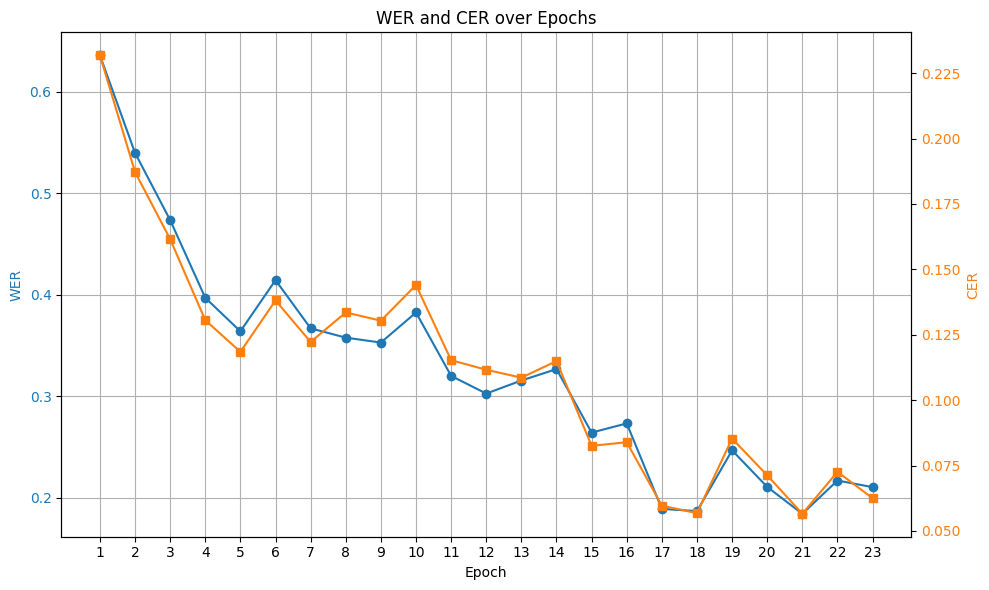

In [ ]:
# Plot WER and CER over epochs
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WER
ax1.set_xlabel('Epoch')
ax1.set_ylabel('WER', color='tab:blue')
ax1.plot(epochs, avg_wer_list, color='tab:blue', marker='o', label='WER')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for CER
ax2 = ax1.twinx()
ax2.set_ylabel('CER', color='tab:orange')
ax2.plot(epochs, avg_cer_list, color='tab:orange', marker='s', label='CER')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set x-ticks to integer values only (1, 2, 3, ...)
ax1.set_xticks(np.arange(1, len(epochs) + 1))

# Add title and grid
plt.title('WER and CER over Epochs')
ax1.grid(True)

# Show plot
plt.tight_layout()
plt.show()


# Benchmarking - Whisper, vosk and Confomer on LIBRISPEECH dev-clean

In [34]:
import os
import torch
import torchaudio
from torchaudio.datasets import LIBRISPEECH
import numpy as np
from vosk import Model, KaldiRecognizer
import jiwer
import wave
import json
from tqdm import tqdm
import time

def load_librispeech_dataset(root_dir, split):
    """Load LibriSpeech dataset using torchaudio"""
    try:
        dataset = LIBRISPEECH(root=root_dir, url=split)
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def calculate_metrics(references, hypotheses):
    """Calculate WER and CER"""
    # Word Error Rate
    wer = jiwer.wer(references, hypotheses)
    
    # Character Error Rate
    cer = jiwer.cer(references, hypotheses)
    
    return wer, cer

def transcribe_audio_with_vosk(audio_tensor, sample_rate, model):
    """Transcribe audio using Vosk model"""
    # Convert to 16-bit PCM
    audio_np = (audio_tensor * 32768).numpy().astype(np.int16)
    
    if len(audio_np.shape) > 1:
        audio_np = audio_np[0]  # Get mono audio
    
    # Create recognizer with the model
    rec = KaldiRecognizer(model, sample_rate)
    rec.SetWords(True)
    
    # Process audio in chunks
    chunk_size = int(sample_rate * 0.1)  # Process 0.1 second chunks
    transcription = ""
    
    for i in range(0, len(audio_np), chunk_size):
        chunk = audio_np[i:min(i + chunk_size, len(audio_np))].tobytes()
        if rec.AcceptWaveform(chunk):
            result = json.loads(rec.Result())
            transcription += result.get("text", "") + " "

    # Get final result
    final_result = json.loads(rec.FinalResult())
    transcription += final_result.get("text", "")
    
    return transcription.strip()

def evaluate_model(model_path, dataset_path, split="test-clean"):
    """Evaluate Vosk model on LibriSpeech dataset"""
    # Load Vosk model
    try:
        model = Model(model_path)
    except Exception as e:
        print(f"Error loading Vosk model: {e}")
        return
    
    # Load dataset
    dataset = load_librispeech_dataset(dataset_path, split)
    if not dataset:
        return
    
    references = []
    hypotheses = []
    
    total_time = 0  # Track total inference time
    num_samples = 0  # Track number of samples processed

    # Process samples
    for idx in tqdm(range(400), desc="Processing samples"):
        try:
            waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset[idx]
            
            # Get reference text
            reference = utterance.lower()
            references.append(reference)
            
            # Time the transcription step
            start_time = time.time()
            hypothesis = transcribe_audio_with_vosk(waveform, sample_rate, model)
            end_time = time.time()

            inference_time = end_time - start_time
            total_time += inference_time
            num_samples += 1
            
            hypotheses.append(hypothesis)
            
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
    
    # Calculate average inference time
    avg_inference_time = total_time / num_samples if num_samples > 0 else 0
    
    # Calculate metrics
    wer, cer = calculate_metrics(references, hypotheses)
    
    print("\n===== Results =====")
    print(f"Word Error Rate (WER): {wer:.4f}")
    print(f"Character Error Rate (CER): {cer:.4f}")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds per sample")
    
    return wer, cer, avg_inference_time

model_path = "../vosk-model-en-us-0.22-lgraph"
dataset_path = "../data"
split = "test-clean"
evaluate_model(model_path, dataset_path, split)

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:11:12:13:14:15
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from ../vosk-model-en-us-0.22-lgraph/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from ../vosk-model-en-us-0.22-lgraph/graph/HCLr.fst ../vosk-model-en-us-0.22-lgraph/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo ../vosk-model-en-us-0.22-lgraph/graph/phones/word_boundary.int
Processing samples: 100%|██████████| 400/400 [43:22<00:00,  6.51s/it]



===== Results =====
Word Error Rate (WER): 0.0633
Character Error Rate (CER): 0.0217
Average Inference Time: 6.5010 seconds per sample


(0.06328972380632897, 0.021749637506041565, 6.500983206033706)

In [ ]:
import torch
import torchaudio
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC
from jiwer import wer, cer
from tqdm import tqdm

# Check if CUDA is available and use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Wav2Vec2 model, tokenizer, and feature extractor from Hugging Face
model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

# Load LibriSpeech test-clean dataset using torchaudio
dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="test-clean", download=True)

# Function to transcribe audio and return text
def transcribe_audio(audio):
    # Extract audio and sample rate from dataset
    waveform, sample_rate = audio
    waveform = waveform.squeeze(0).to(device)  # Move the waveform to the GPU
    input_values = feature_extractor(waveform, sampling_rate=16000, return_tensors="pt").input_values.to(device)

    # Perform inference with the model
    with torch.no_grad():
        logits = model(input_values).logits
    pred_ids = torch.argmax(logits, dim=-1)

    # Decode the prediction
    transcription = tokenizer.decode(pred_ids[0])
    return transcription

# Initialize variables to calculate WER and CER
all_predictions = []
all_references = []

# Iterate over the dataset and transcribe each audio file
for sample in tqdm(dataset):
    # Extract the reference (transcript)
    reference = sample[2].lower()

    # Get the audio waveform
    audio = (sample[0], 16000)  # Use 16kHz sample rate as the model was trained on it

    # Get the predicted transcription from the audio
    predicted = transcribe_audio(audio).lower()

    # Append the predicted and reference transcriptions
    all_predictions.append(predicted)
    all_references.append(reference)

# Calculate WER and CER
wer_score = wer(all_references, all_predictions)
cer_score = cer(all_references, all_predictions)

# Print results
print(f"Word Error Rate (WER): {wer_score * 100:.2f}%")
print(f"Character Error Rate (CER): {cer_score * 100:.2f}%")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2620/2620 [01:37<00:00, 26.89it/s]


Word Error Rate (WER): 3.39%
Character Error Rate (CER): 0.96%


In [35]:
import pandas as pd
from tabulate import tabulate

# Dummy model data (you can replace these values with your actual results)
models = ["Conformer", "vosk-model-en-us-0.22-lgraph", "wav2vec2-base-960h"]
wer = [18.59, 6.33, 3.39]  # Word Error Rate (WER) in percentage
cer = [5.68, 2.17, 0.96]  # Character Error Rate (CER) in percentage
parameters = ["82M", "80M", "95M"]  # Number of parameters (dummy values)
dataset_size = ["360 (LIBRISPEECH)", "960 (LIBRISPEECH)", "960 (LIBRISPEECH)"]

# Create a DataFrame
data = {
    "Model": models,
    "WER (%)": wer,
    "CER (%)": cer,
    "Parameters (Millions)": parameters,
    "Training Dataset Length (Hours)": dataset_size,
}

df = pd.DataFrame(data)

# Display the table in a beautiful format
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))



╒══════════════════════════════╤═══════════╤═══════════╤═════════════════════════╤═══════════════════════════════════╕
│ Model                        │   WER (%) │   CER (%) │ Parameters (Millions)   │ Training Dataset Length (Hours)   │
╞══════════════════════════════╪═══════════╪═══════════╪═════════════════════════╪═══════════════════════════════════╡
│ Conformer                    │     18.59 │      5.68 │ 82M                     │ 360 (LIBRISPEECH)                 │
├──────────────────────────────┼───────────┼───────────┼─────────────────────────┼───────────────────────────────────┤
│ vosk-model-en-us-0.22-lgraph │      6.33 │      2.17 │ 80M                     │ 960 (LIBRISPEECH)                 │
├──────────────────────────────┼───────────┼───────────┼─────────────────────────┼───────────────────────────────────┤
│ wav2vec2-base-960h           │      3.39 │      0.96 │ 95M                     │ 960 (LIBRISPEECH)                 │
╘══════════════════════════════╧═══════════╧════